# Model training and prediction

This file implements the LightGBM method. Hyperparameters are set and the model is trained. Afterwards the model is saved in `../models/model_M1.p`.

Validating the model with values from the test set is implemented at the end. A list of all used features sorted by their importance is also printed out.

***

Optional befor training the model (not mentioned in this code):

To gain a good fitting model, hyperparameters are tuned. Bayesian Hyperparameter Optimization was used for that job (with the hyperopt-library).

In this process, a 3 folded Cross Validation was used to return the best fitted model.

***

## import libraries / delcare functions

In [6]:
import os
os.chdir('G:\\DataScience\\shiva time\\Microsoft Malware Prediction')

In [2]:
!pip install lightgbm

In [3]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
import lightgbm as lgb
import pickle


In [44]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [4]:
def convert_types(df):
    # Convert data types to reduce memory
    for c in df:
        col_type = str(df[c].dtypes)
        numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
        
        # Convert objects to category
        if col_type == 'object':
            df[c] = df[c].astype('category')
        
        # numerics
        elif col_type in numerics:
            c_min = df[c].min()
            c_max = df[c].max()
            if col_type[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[c] = df[c].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[c] = df[c].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[c] = df[c].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[c] = df[c].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[c] = df[c].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[c] = df[c].astype(np.float32)
                else:
                    df[c] = df[c].astype(np.float64)  
        
    return df

## Import Data

In [8]:
filetrain = 'train_M1.csv'
ddf = dd.read_csv(filetrain)
train = ddf.compute()
train = convert_types(train)
filetest = 'test_M1.csv'
ddf = dd.read_csv(filetest)
test = ddf.compute()
test = convert_types(test)

C:\Users\bharat\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in less
C:\Users\bharat\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in less


In [9]:
# target column
target = 'HasDetections'
# id from data set
data_id = 'MachineIdentifier'

In [10]:
train.shape

(300000, 72)

In [11]:
test.shape
# rows=7.853.253

(5000, 72)

# Model Training

## prepare files for training and prediction

In [12]:
# labels from train file
train_labels = np.array(train[target].astype(np.int8)).reshape((-1, ))

In [13]:
# remove target and data_id for model training
train = train.drop(columns = [target, data_id])

In [14]:
# save data_id for submission file
test_ids = list(test[data_id])

In [15]:
# remove target and data_id for prediction
test = test.drop(columns = [target, data_id])

## Set parameters for LightGBM algorithm

In [16]:
# Categorical features for LighGBM parameter
categorical_feature = ['OsPlatformSubRelease',
 'Census_MDC2FormFactor_new',
 'Census_FlightRing',
 'Census_PrimaryDiskTypeName',
 'Census_OSSkuName',
 'Census_OSBranch',
 'OsVer',
 'SkuEdition',
 'Census_OSArchitecture',
 'Census_OSEdition',
 'Census_GenuineStateName',
 'Processor',
 'SmartScreen',
 'Census_OSInstallTypeName',
 'Census_OSWUAutoUpdateOptionsName',
 'Census_ChassisTypeName',
 'Census_MDC2FormFactor',
 'Platform',
 'Census_DeviceFamily',
 'Census_ActivationChannel',
 'Census_PowerPlatformRoleName',
 'Census_InternalPrimaryDiagonalDisplaySizeInInches',
 'Census_ProcessorCoreCount',
 'Census_HasOpticalDiskDrive',
 'Census_IsAlwaysOnAlwaysConnectedCapable',
 'Census_IsPenCapable',
 'Census_IsPortableOperatingSystem',
 'Census_IsSecureBootEnabled',
 'Census_IsTouchEnabled',
 'Census_IsVirtualDevice',
 'Firewall',
 'HasTpm',
 'IsProtected',
 'IsSxsPassiveMode',
 'SMode',
 'Wdft_IsGamer']

In [17]:
best_hyp = {'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.6110437067662637,
 'learning_rate': 0.0106,
 'min_child_samples': 295,
 'num_leaves': 160,
 'reg_alpha': 0.6321152748961743,
 'reg_lambda': 0.6313659622714517,
 'subsample_for_bin': 80000,
 'subsample': 0.8202307264855064}

In [18]:
estimators = 12000

In [19]:
from sklearn.model_selection import train_test_split

In [21]:
X_train, X_test, y_train, y_test = train_test_split(train, train_labels, test_size=0.33, random_state=42)

## Train model

In [22]:
train_set = lgb.Dataset(train, label = train_labels)

In [23]:
# Re-create the best model and train on full training data
model = lgb.LGBMClassifier(n_estimators=estimators, n_jobs = -1, 
                                       objective = 'binary', random_state = 50, **best_hyp)

In [24]:
model.fit(X_train, y_train, categorical_feature=categorical_feature)
# time: 1h 52min 39s

C:\Users\bharat\Anaconda3\lib\site-packages\lightgbm\basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Census_ActivationChannel', 'Census_ChassisTypeName', 'Census_DeviceFamily', 'Census_FlightRing', 'Census_GenuineStateName', 'Census_HasOpticalDiskDrive', 'Census_InternalPrimaryDiagonalDisplaySizeInInches', 'Census_IsAlwaysOnAlwaysConnectedCapable', 'Census_IsPenCapable', 'Census_IsPortableOperatingSystem', 'Census_IsSecureBootEnabled', 'Census_IsTouchEnabled', 'Census_IsVirtualDevice', 'Census_MDC2FormFactor', 'Census_MDC2FormFactor_new', 'Census_OSArchitecture', 'Census_OSBranch', 'Census_OSEdition', 'Census_OSInstallTypeName', 'Census_OSSkuName', 'Census_OSWUAutoUpdateOptionsName', 'Census_PowerPlatformRoleName', 'Census_PrimaryDiskTypeName', 'Census_ProcessorCoreCount', 'Firewall', 'HasTpm', 'IsProtected', 'IsSxsPassiveMode', 'OsPlatformSubRelease', 'OsVer', 'Platform', 'Processor', 'SMode', 'SkuEdition', 'SmartScreen', 'Wdft_Is

LGBMClassifier(boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.6110437067662637, importance_type='split',
               learning_rate=0.0106, max_depth=-1, min_child_samples=295,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=12000,
               n_jobs=-1, num_leaves=160, objective='binary', random_state=50,
               reg_alpha=0.6321152748961743, reg_lambda=0.6313659622714517,
               silent=True, subsample=0.8202307264855064,
               subsample_for_bin=80000, subsample_freq=0)

In [27]:
model.score(X_test,y_test)

0.6428989898989899

## save model

In [25]:
pickle.dump(model, open("model_M1.p", "wb"))
#model = pickle.load(open("model/model_M1.p", "rb"))

# predict on Test set

In [28]:
preds = model.predict(X_test)
# time: 40min 42s

In [29]:
preds

array([0, 1, 0, ..., 1, 1, 1], dtype=int8)

In [33]:
pickle.dump(preds, open("preds_M1.p", "wb"))
#preds=pickle.load(open("preds_M1.p", "rb"))

In [40]:
def plot_roc_auc(y_test, preds):
    '''
    Takes actual and predicted(probabilities) as input and plots the Receiver
    Operating Characteristic (ROC) curve
    '''
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

Classification Report for K-Nearest Neighbours: 
               precision    recall  f1-score   support

           0       0.64      0.65      0.64     49659
           1       0.64      0.64      0.64     49341

    accuracy                           0.64     99000
   macro avg       0.64      0.64      0.64     99000
weighted avg       0.64      0.64      0.64     99000

Confusion Matrix of K-Nearest Neigbours: 
 [[32106 17553]
 [17800 31541]]


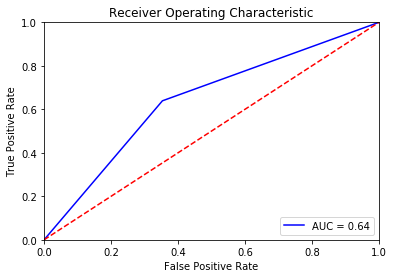

In [45]:
print("Classification Report for K-Nearest Neighbours: \n", classification_report(y_test, preds))
print("Confusion Matrix of K-Nearest Neigbours: \n", confusion_matrix(y_test, preds))
plot_roc_auc(y_test, preds)

In [ ]:
preds_test = model.predict(test)

In [19]:
# create submission
submission = pd.DataFrame({data_id: test_ids, target: preds_test})

In [20]:
submission.shape


(7853253, 2)

In [21]:
submission.head()

,MachineIdentifier,HasDetections
0,0000010489e3af074adeac69c53e555e,0.519442
1,00000176ac758d54827acd545b6315a5,0.652767
2,0000019dcefc128c2d4387c1273dae1d,0.548672
3,0000055553dc51b1295785415f1a224d,0.392367
4,00000574cefffeca83ec8adf9285b2bf,0.556916


In [22]:
# save submission file
submission.to_csv('Submission_M1.csv', index = False)

# Feature Importance

In [23]:
# list of all features
feature_names = list(train.columns)

In [24]:
# create feature importance
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': model.feature_importances_})

In [25]:
# sort for most important
feature_importances = feature_importances.sort_values('importance', ascending = False).reset_index(drop = True)

In [26]:
# calculate normalized and cumulative feature importance
feature_importances['normalized_importance'] = feature_importances['importance'] / feature_importances['importance'].sum()
feature_importances['cumulative_importance'] = np.cumsum(feature_importances['normalized_importance'])

In [27]:
feature_importances

,feature,importance,normalized_importance,cumulative_importance
0,Census_InternalPrimaryDiagonalDisplaySizeInInches,152814,0.080091,0.080091
1,AvSigVersion,92491,0.048475,0.128567
2,CountryIdentifier,85290,0.044701,0.173268
3,CityIdentifier,77592,0.040667,0.213934
4,AVProductStatesIdentifier,76013,0.039839,0.253774
5,Census_SystemVolumeTotalCapacity,72400,0.037945,0.291719
6,index,69242,0.036290,0.328009
7,Census_OSInstallTypeName,68891,0.036106,0.364116
8,Census_ProcessorModelIdentifier,67113,0.035175,0.399290
9,Census_FirmwareVersionIdentifier,66093,0.034640,0.433930


In [28]:
feature_importances.to_csv('../feature_importances/FeatureImportance_M1.csv', index = False)